## SIG-Statistics
Wouter Kouw, 15-06-2018

### Importance-weighting for classification problems with selection biases.

In this notebook, I will show you a classification problem that contains _sample selection bias_. Selection bias occurs when you collect data non-uniformly across a population. For instance, in psychology, measurements are often performed on bachelor students at a university. These students differ from the national population on variables such as age, health, and income, and are therefore a biased sample from the population.

The problem with biased samples is that certain events/outcomes are observed more or less frequently than they would be in the larger population. To control for this, the events should be re-weighed to the appropriate probability. This re-weighing procedure can be interpreted as assigning a value to each instance from biased sample based on how important that instance is with respect to the population. Therefore, the controlling procedure is called _importance-weighting_.

Note: since the data is randomly generated, some captions in this notebook will sometimes not accurately describe the figures. If that happens, re-run.

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import sklearn.linear_model as lm
import sklearn.svm as sv
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
# Visualization parameters
%matplotlib inline
import matplotlib.pyplot as plt

fig_size = (12,10)
scatter_size = 100
axes_size = 20
plt.rc('font', size=axes_size)
plt.rc('axes', titlesize=axes_size)
plt.rc('axes', labelsize=axes_size)
plt.rc('xtick', labelsize=axes_size)
plt.rc('ytick', labelsize=axes_size)
plt.rc('legend', fontsize=axes_size)
plt.rc('figure', titlesize=axes_size)

In [3]:
# The following functions are unknown to you.

def py(y):
    """Class distribution."""
    return 1./2

def px(x1, x2):
    """Data distribution."""
    mu = np.zeros((2,))
    Si = np.array([[2,0],[0,2]])
    return st.multivariate_normal.pdf(-np.vstack((x1,x2)).T*2, mean=mu, cov=Si)

def pyx(y,x1,x2):
    """Posterior function."""
    mu = np.zeros((2,))
    Si = np.array([[.1,0],[0,.1]])
    return (y<0) + y*st.multivariate_normal.cdf(-np.vstack((x1,x2)).T*2, mean=mu, cov=Si)

def pxy(y,x1,x2):
    """Class-conditional function."""
    return pyx(y, x1, x2)*px(x1, x2)/py(y)


In [4]:
# Rejection sampling

def reject_sample2D(p, M, N, b1=(0,1), b2=(0,1)):
    """
    Perform rejection sampling on a supplied 2D distribution function.
    
    Arguments
    ---------
    p : function
        A probability distribution function, from which needs to be sampled.
    M : int
        Upper bound on pdf.
    N : int
        Number of samples to draw from
    b1 : tuple(int, int)
        Range limits for first dimension
    b2 : tuple(int, int)
        Range limits for second dimension
        
    Returns
    -------
    array
        N 2-dimensional samples drawn from pdf p.  
    """
    
    # Initialize
    n = 0;
    c = 0;

    # Preallocate
    X = np.zeros((N,2));

    while n < N:

        # Generate grid uniform random values
        x = st.uniform(loc=(b1[0], b2[0]), scale=(b1[1]-b1[0], b2[1]-b2[0])).rvs(size=(2*N, 2))

        # Generate proposal values
        uM = M*rnd.rand(2*N,)

        # Accept samples
        x = x[uM < p(x[:,0], x[:,1]), :]

        # Number of accepted samples
        nA = x.shape[0]

        # Add to existing set
        X[n:min(n + nA, N), :] = x[:min(nA, N - n), :]

        # Tick up
        n += nA;    
        c += 1;

        # Check for stalling
        if c > 1e4:
            error('too many iterations');
            
    return X

In [5]:
def plotdc(clf, ax, color='k', gridsize=(1001, 1001), linestyle='-'):
    """
    Plot the decision boundary of a classifier in a 2D scatterplot.

    Arguments
    ---------
    parameters : array(D+1,1)
        classifier parameters / weights
    ax : Axes object
        axes of a pyplot figure or subject
    colors : str
        colors of the contours in the plot (def: 'k')
    gridsize : tuple(int,int)
        number of points in the grid (def: (101, 101))
        
    Returns
    -------
    None
    """
    # Get axes limits
    xl = ax.get_xlim()
    yl = ax.get_ylim()

    # Define grid
    gx = np.linspace(xl[0], xl[1], gridsize[0])
    gy = np.linspace(yl[0], yl[1], gridsize[1])
    x, y = np.meshgrid(gx, gy)
    xy = np.vstack((x.ravel(), y.ravel())).T

    # Values of grid
    z = clf.predict(xy).reshape(gridsize)

    # Plot grid
    ax.contour(x, y, z, levels=0, colors=color, linestyles=linestyle)

## General population

We are interesting in building a classifier that makes predictions for a general population. In the following example, this population, \\( p(x) \\), is spread according to a normal distribution centered at [0,0]. There is a stochastic classification function, \\( p(y \mid x) \\), that separates the two. However, this function is unknown to us.

In [6]:
# Rejection sampling intervals
b1 = [-5, 5]
b2 = [-5, 5]

In [7]:
# Construct our unbiased unlabeled test data

# Sample sizes (M for testing)
M = 1000

# Perform rejection sampling to obtain data from data distribution p(x)
Z = reject_sample2D(lambda x1,x2: px(x1,x2), 1, M, b1=b2, b2=b2)

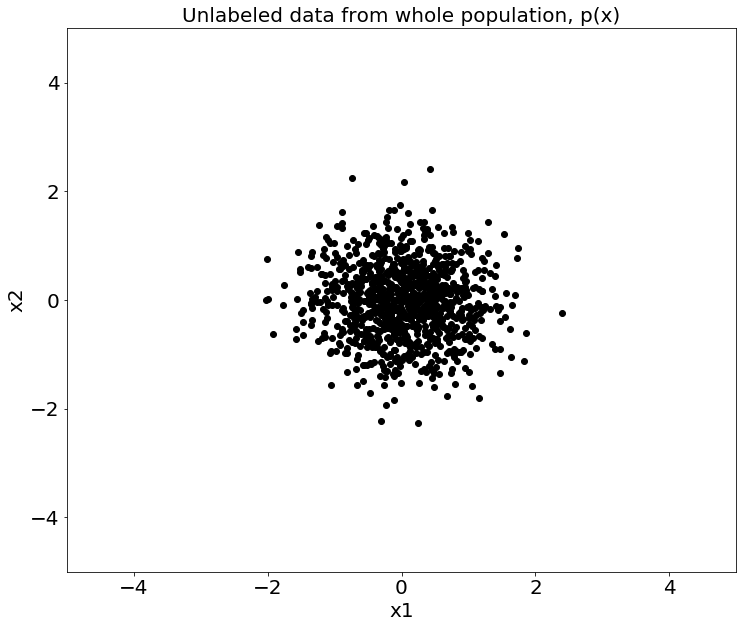

In [8]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(Z[:,0], Z[:,1], c='k')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Unlabeled data from whole population, p(x)');

## Draw sample with a selection bias

We would like to collect training data so that we can fit a classification model and make predictions. However, unfortunately, we can only sample from a particular region of it. For instance, if the population represented a country, and I went to collect data in a single city. I might collect data on some visitors from other cities, but in general I will be getting a very local view on the population.

For the moment, the data distribution conditioned on the sampling distribution, will be a normal distribution that is centered on the point [-1, 0] and has a variance of \\(\sqrt{2} / 2 \\) for both dimensions. I expect to be drawing instances mostly from the left half of the grid. This new data distribution will be referred to as \\( p(x \mid s=1) \\), where \\( s=1 \\) signifies 'selection is true'.

In [9]:
def pxs(x1, x2):
    """Data distribution conditioned on the probability of being selected, p(x | s=1)."""
    return st.multivariate_normal.pdf(x=np.vstack((x1,x2)).T, mean=np.array([-1, 0]), cov=np.sqrt(2)/2.*np.eye(2))

def pxsy(y, x1, x2):
    """Class-conditional distribution."""
    return pyx(y, x1, x2)*pxs(x1, x2) / py(y)

# Sample size
N = 100

# Sample from positive class (i.e. y=+1)
Xp = reject_sample2D(lambda x1,x2: pxsy(+1, x1, x2), 1, int(N*py(+1)), b1=b1, b2=b2)

# Sample from negative class (i.e. y=-1)
Xn = reject_sample2D(lambda x1,x2: pxsy(-1, x1, x2), 1, int(N*py(-1)), b1=b1, b2=b2)

# Concatenate both sets
X = np.vstack((Xp, Xn))

# Make label vector
y = np.hstack((-np.ones(Xp.shape[0],), np.ones(Xn.shape[0],))).T

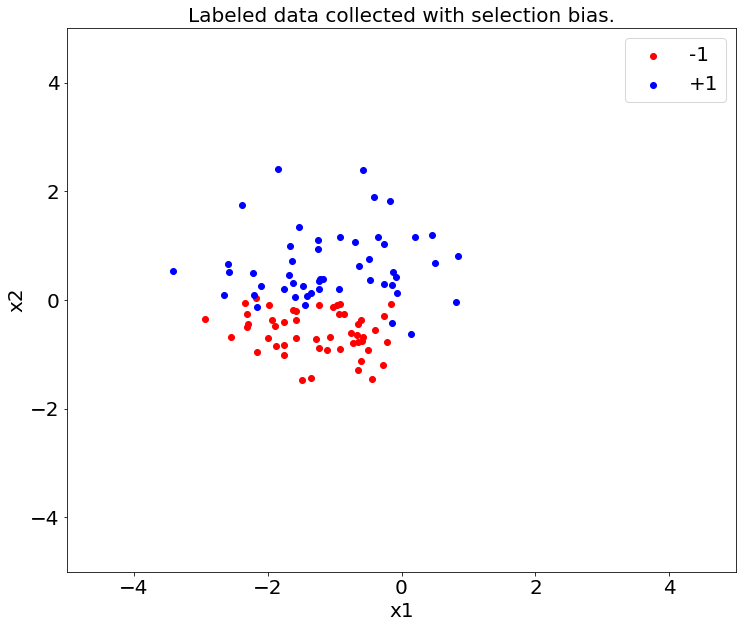

In [10]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)

ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

In [11]:
# Fit a linear model and make predictions

# Initialize polynomial SVM of degree 1
model1 = sv.SVC(kernel='poly', degree=1)

# Perform grid search cross-validation to find optimal C
grid_searcher = GridSearchCV(model1, param_grid=dict(C=np.logspace(-4,3,8))).fit(X,y)
model1 = sv.SVC(kernel='poly', degree=1, C=grid_searcher.best_estimator_.C)

# Fit on training data
model1.fit(X,y);

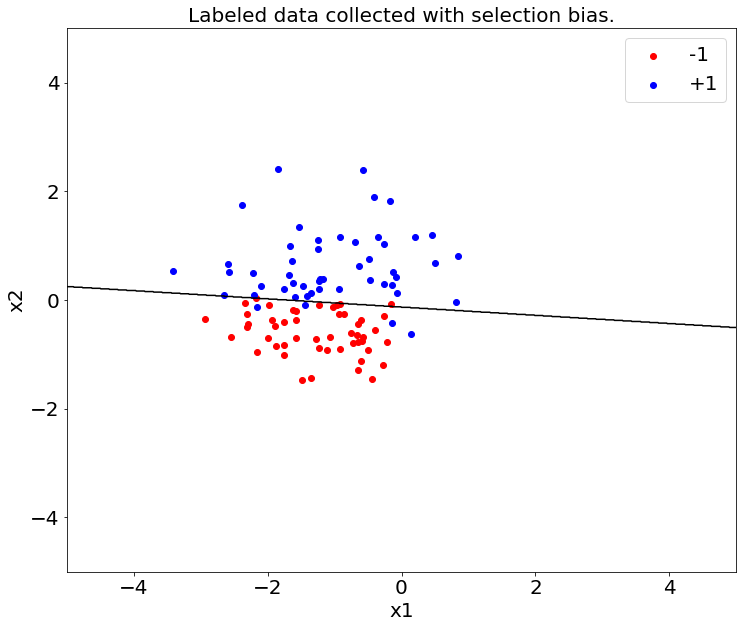

In [12]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)

ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model1, ax, color='k')

In [13]:
# Draw a test set from the whole population

# Sample from positive class (i.e. y=+1)
Zp = reject_sample2D(lambda x1,x2: pxy(+1, x1, x2), 1, int(M*py(+1)), b1=b1, b2=b2)

# Sample from negative class (i.e. y=-1)
Zn = reject_sample2D(lambda x1,x2: pxy(-1, x1, x2), 1, int(M*py(-1)), b1=b1, b2=b2)

# Concatenate both sets
Z = np.vstack((Zp, Zn))

# Make label vector
u = np.hstack((-np.ones(Zp.shape[0],), np.ones(Zn.shape[0],))).T

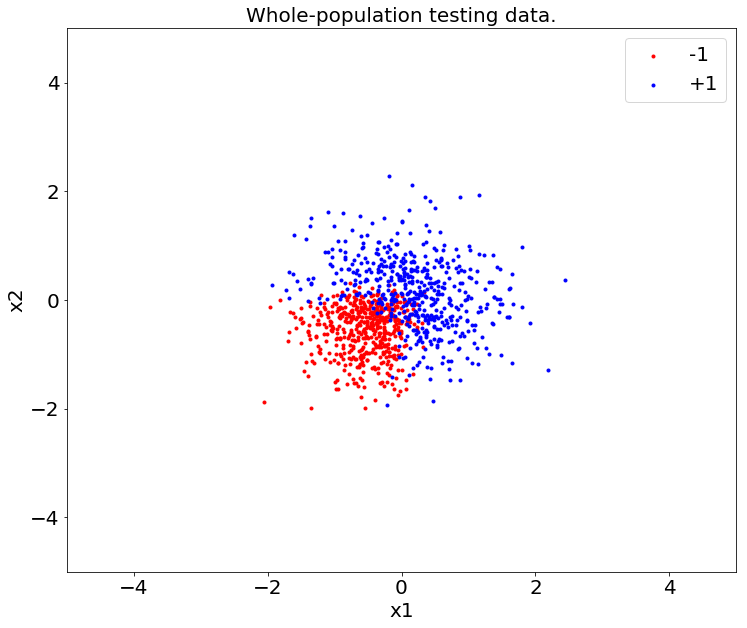

In [14]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)

ax.scatter(Z[u==-1, 0], Z[u==-1, 1], c='r', marker='.', label='-1')
ax.scatter(Z[u==+1, 0], Z[u==+1, 1], c='b', marker='.', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Whole-population testing data.');

In [15]:
# Model accuracy on whole population
print('Accuracy on testing set: ' + str(model1.score(Z, u)))

Accuracy on testing set: 0.784


### Model misspecification

You might think that this is a model mis-specification problem (fitting a nonlinear \\(p(y \mid x) \\) with a linear classifier), and you're partially right. However, increasing the degree of the polynomial classifier, thereby increasing the non-linearity, can worsen your predictions.

In [16]:
# Increase degree of polynomial to 2 (quadratic)

# Initialize polynomial SVM to degree 2
model2 = sv.SVC(kernel='poly', degree=2)

# Perform grid search cross-validation to get optimal C
grid_searcher = GridSearchCV(model2, param_grid=dict(C=np.logspace(-4,3,8))).fit(X,y)
model2 = sv.SVC(kernel='poly', degree=2, C=grid_searcher.best_estimator_.C)

# Fit on training data
model2.fit(X,y);

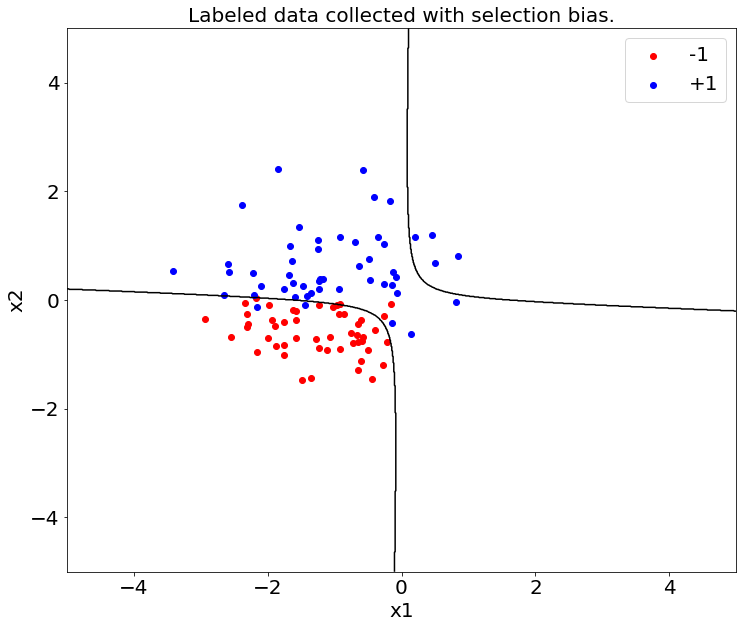

In [17]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', label='+1')

ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model2, ax, color='k')

In [18]:
# Model accuracy

print('Accuracy of degree-1 polynomial SVM on test set: ' + str(model1.score(Z, u)))
print('Accuracy of degree-2 polynomial SVM on test set: ' + str(model2.score(Z, u)))

Accuracy of degree-1 polynomial SVM on test set: 0.784
Accuracy of degree-2 polynomial SVM on test set: 0.721


## Importance-weighting

The model doesn't account for the change in $ p(y \mid x) $ that occurs as the data shifts from the biased sample, $ p(x \mid s=1) $, to the whole population, $ p(x) $. Only a few samples of its training set point to the fact that the decision boundary might be curving downwards.

However, the biased sample can be "debiased" by taking into account that certain samples were more likely to be observed than others. If we weigh each $ p(x_i \mid s=1) $ by a factor of $ p(x_i)/p(x_i \mid s=1) $, then we obtain their probability under the whole population $ p(x) $. 

This reweighting factor is motivated from the risk minimization perspective. A risk function is the expected loss that a classifier $ h $ incurs on a given joint distribution:

$$ \int_{\mathcal{X}} \sum_{y \in \mathcal{Y}} \ell( h(x), y) p(x,y) \mathrm{d} x $$

where $\mathcal{X}$ is the sample space (a.k.a. feature space / input space), and $ \mathcal{Y} $ is the label \ class space. $ h(x) $ is the classifier's prediction for instance $ x $, and the loss function $ \ell $ compares that prediction with the true label. Risk functions are expectations, which can be approximated using sample averages (law of large numbers):

$$ \mathbb{E}_{\mathcal{X,Y}} [ \ell( h(x), y) ] \approx \frac{1}{n} \sum_{i=1}^{n} \ell(h(x_i), y_i) $$

When you use data from the biased sample, you are actually approximating the expected with respect to $p(x \mid s=1)$; 

$$ \int_{\mathcal{X}} \sum_{y \in \mathcal{Y}} \ell( h(x), y) p(y, x \mid s=1) \mathrm{d} x \, .$$

However, you can re-write the whole population risk in terms of a re-weighted biased sample risk:

$$ \int_{\mathcal{X}} \sum_{y \in \mathcal{Y}} \ell( h(x), y) p(x,y) \mathrm{d} x = \int_{\mathcal{X}} \sum_{y \in \mathcal{Y}} \ell( h(x), y) \frac{p(x,y)}{p(y,x \mid s=1)} p(y, x\mid s=1) \mathrm{d} x $$

The current reweighting factor, $ p(x,y) / p(y, x \mid s=1) $, suggests that we would need labeled data from the whole population, i.e $(x,y) \sim p(x,y)$. But in this case, we know that $p(y \mid x)$ is the same for both the whole population and the biased sample (not always the case). That allows you to perform the following simplification:

$$ \frac{p(x,y)}{p(y, x \mid s=1)} = \frac{p(y \mid x) p(x)}{p(y \mid x) p(x \mid s=1)} = \frac{p(x)}{p(x \mid s=1)} $$

In [19]:
# Importance weight distribution

def w_true(x):
    """True weight distribution"""
    return px(x[:,0], x[:,1]) / pxs(x[:,0], x[:,0]) 

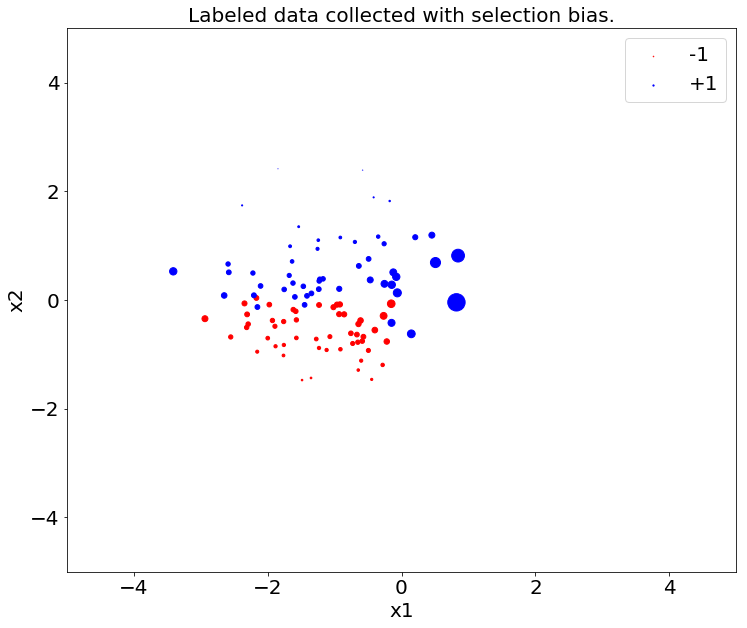

In [20]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=w_true(X[y==-1, :])*scatter_size, label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=w_true(X[y==+1, :])*scatter_size, label='+1')

ax.legend(markerscale=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

### Incorporating importance weights in your model

Importance-weights are only used during training. They act as scaling variables on the loss that the model incurs for each sample. Essentially, you are telling your model that it is 'very bad' to misclassify certain samples (the ones that you assigned a large importance value to) and that it is not so bad to misclassify others (the ones that you assigned a small importance value).

In [21]:
# Fit a weighted model and make predictions

# Cross-validate SVM for optimal C
model3 = sv.SVC(kernel='poly', degree=1)
grid_searcher = GridSearchCV(model3, param_grid=dict(C=np.logspace(-4,3,8))).fit(X,y, sample_weight=w_true(X))
model3 = sv.SVC(kernel='poly', degree=1, C=grid_searcher.best_estimator_.C)

# Fit on given data
model3.fit(X,y, sample_weight=w_true(X));

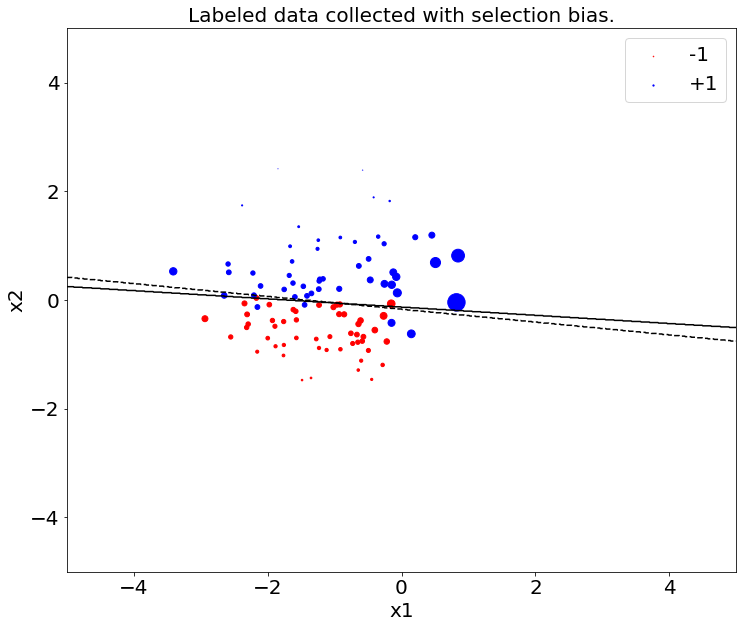

In [22]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=w_true(X[y==-1, :])*scatter_size, label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=w_true(X[y==+1, :])*scatter_size, label='+1')

ax.legend(markerscale=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model1, ax, linestyle='-')
plotdc(model3, ax, linestyle='--')

In [23]:
# Model accuracy

print('Accuracy of degree-1 polynomial SVM on test set: ' + str(model1.score(Z, u)))
print('Accuracy of weighted degree-1 polynomial SVM on test set: ' + str(model3.score(Z, u)))

Accuracy of degree-1 polynomial SVM on test set: 0.784
Accuracy of weighted degree-1 polynomial SVM on test set: 0.783


We can do the same for the degree-2 poly-SVM. But be warned: with more complex models, overfitting becomes an issue. Weighting samples increases the classifier's variance which potentially increases overfitting as well (see last section of notebook).

In [24]:
# Fit a weighted degree-2 model and make predictions

# Cross-validate SVM for optimal C
model4 = sv.SVC(kernel='poly', degree=2)
grid_searcher = GridSearchCV(model4, param_grid=dict(C=np.logspace(-4,3,8))).fit(X,y, sample_weight=w_true(X))
model4 = sv.SVC(kernel='poly', degree=2, C=grid_searcher.best_estimator_.C)

# Fit on given data
model4.fit(X,y, sample_weight=w_true(X));

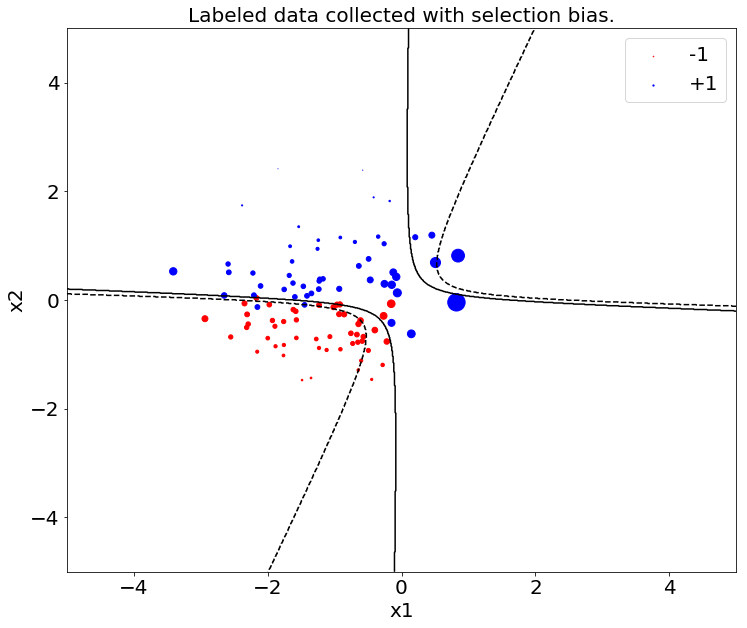

In [25]:
# Scatterplot the data

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=w_true(X[y==-1, :])*scatter_size, label='-1')
ax.scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=w_true(X[y==+1, :])*scatter_size, label='+1')

ax.legend(markerscale=0.1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_xlim(b1[0], b1[1])
ax.set_ylim(b2[0], b2[1])
ax.set_title('Labeled data collected with selection bias.');

# Plot classifier
plotdc(model2, ax, linestyle='-')
plotdc(model4, ax, linestyle='--')

In [26]:
# Model accuracy

print('Accuracy of degree-2 polynomial SVM on test set: ' + str(model2.score(Z, u)))
print('Accuracy of weighted degree-2 polynomial SVM on test set: ' + str(model4.score(Z, u)))

Accuracy of degree-2 polynomial SVM on test set: 0.721
Accuracy of weighted degree-2 polynomial SVM on test set: 0.618


## Estimating the weight distribution

Of course, in practice you would typically not know either the true data distribution \\( p(x) \\) or the biased sample's distribution \\( p(x \mid s=1) \\). In that case, you would have to estimate them. There are a large variety of parametric and non-parametric importance-weight estimators out there, but for this example we will model both \\( p(x) \\) and \\( p(x \mid s=1) \\) with a normal distribution and take a ratio afterwards.

In [27]:
def w_hat(x, z):
    """Estimated weight distribution, based on two normal distributions."""
    # Estimate means
    mu_x = np.mean(x, axis=0)
    mu_z = np.mean(z, axis=0)
    
    # Estimate variances
    Si_x = np.cov(x.T)
    Si_z = np.cov(z.T)
    
    # Create two distributions
    pxs_hat = st.multivariate_normal(mean=mu_x, cov=Si_x)
    px_hat = st.multivariate_normal(mean=mu_z, cov=Si_z)
    
    # Return the ratio
    return px_hat.pdf(x) / pxs_hat.pdf(x)
    

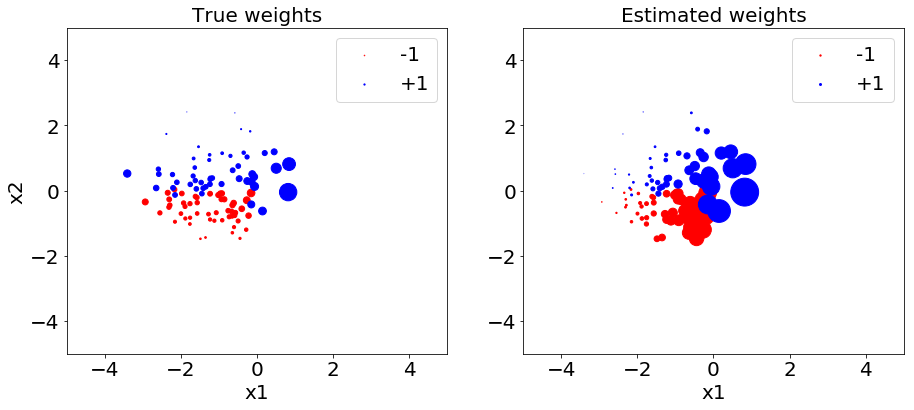

In [28]:
# Scatterplot the data

# First subplot with true weights
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=w_true(X[y==-1, :])*scatter_size, label='-1')
ax[0].scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=w_true(X[y==+1, :])*scatter_size, label='+1')

ax[0].legend(markerscale=0.1)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_xlim(b1[0], b1[1])
ax[0].set_ylim(b2[0], b2[1])
ax[0].set_title('True weights');

# Second subplot with estimated weights
W = w_hat(X, Z)

ax[1].scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=W[y==-1]*scatter_size, label='-1')
ax[1].scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=W[y==+1]*scatter_size, label='+1')

ax[1].legend(markerscale=0.1)
ax[1].set_xlabel('x1')
ax[1].set_xlim(b1[0], b1[1])
ax[1].set_ylim(b2[0], b2[1])
ax[1].set_title('Estimated weights');

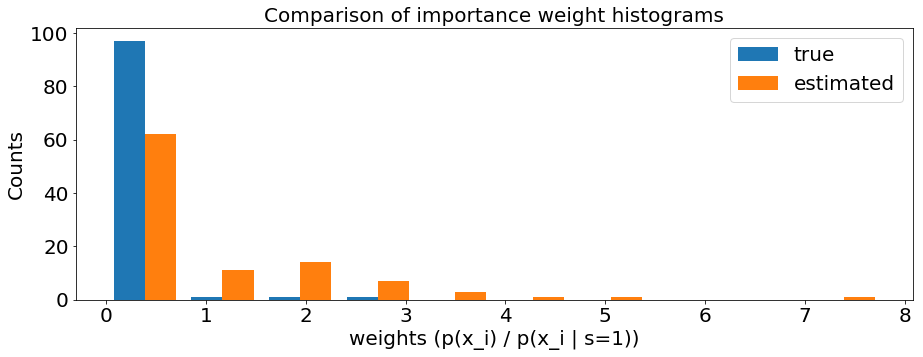

In [29]:
# Visualize the different weight histograms

fig, ax = plt.subplots(figsize=(15, 5))
ax.hist([w_true(X), w_hat(X, Z)], label=['true', 'estimated'])

ax.legend()
ax.set_xlabel('weights (p(x_i) / p(x_i | s=1))')
ax.set_ylabel('Counts')
ax.set_title('Comparison of importance weight histograms');

In [30]:
# Variances of weights

print('Variance of the true weights: ' + str(np.var(w_true(X))))
print('Variance of the estimated weights: ' + str(np.var(w_hat(X, Z))))

Variance of the true weights: 0.12052415172586825
Variance of the estimated weights: 1.718593636082595


Usually, the variance of the estimated weight distribution is larger than that of the true distribution. 

## Sampling variance 

But regardless of weight estimator, the weight histogram will often look bimodal: a few samples will be given very large values and the remaining instances will be given very small values. As the classifier will ignore the many small-weighted instances, the effective sample size of the data set will be much smaller.

If the variance of the importance weights is larger than 1, then the sampling variance of the weighted classifier will also increase. The sampling variance of an estimator (e.g. the unweighted and the weighted parameter estimators for SVM) is related to the classical [_bias-variance tradeoff_](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) in statistical learning. This tradeoff states that more complex classifiers are more accurate (less bias), but are prone to fit on noise which means they change drastically for every data set (more variance). 

You can see this in action if we draw multiple biased samples and train classifiers:

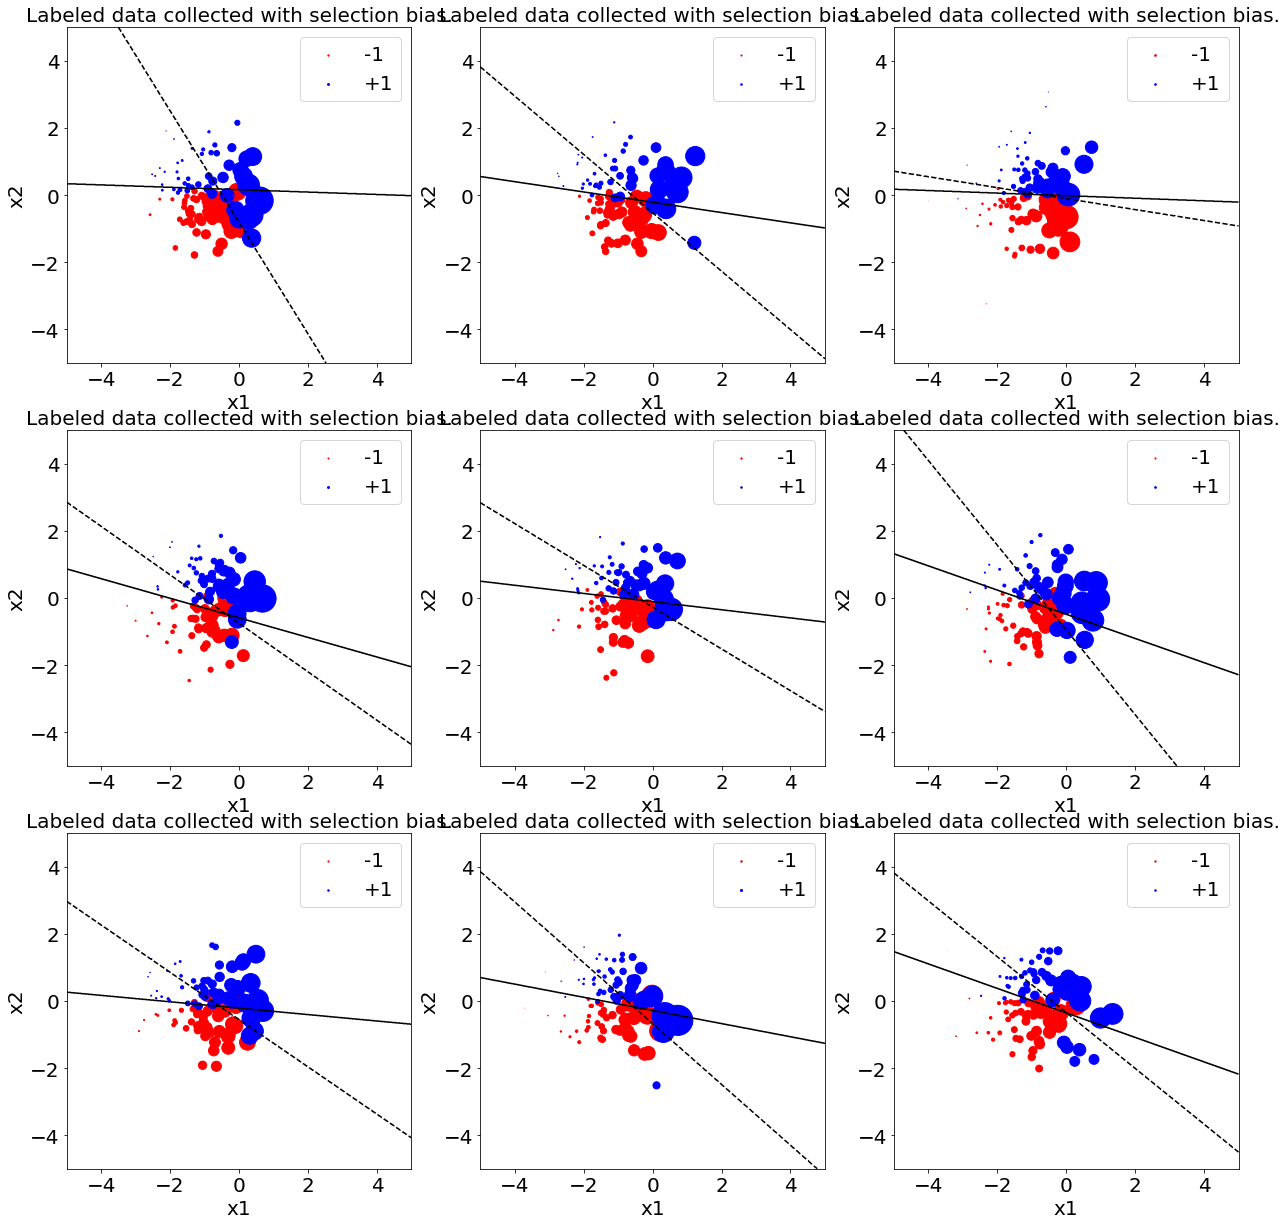

In [31]:
# Loop over several iterations of drawing a biased sample and training classifiers

# Initialize figure
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(21,21))

for i in range(3):
    for j in range(3):
    
        '''Draw sample'''

        # Sample from positive class (i.e. y=+1)
        Xp = reject_sample2D(lambda x1,x2: pxsy(+1, x1, x2), 1, int(N*py(+1)), b1=b1, b2=b2)

        # Sample from negative class (i.e. y=-1)
        Xn = reject_sample2D(lambda x1,x2: pxsy(-1, x1, x2), 1, int(N*py(-1)), b1=b1, b2=b2)

        # Concatenate both sets
        X = np.vstack((Xp, Xn))

        # Make label vector
        y = np.hstack((-np.ones(Xp.shape[0],), np.ones(Xn.shape[0],))).T

        '''Train unweighted classifier'''

        # Train SVM with cross-validation
        model1 = sv.SVC(kernel='poly', degree=1)
        grid_searcher = GridSearchCV(model1, param_grid=dict(C=np.logspace(-4,3,8))).fit(X,y)
        model1 = sv.SVC(kernel='poly', degree=1, C=grid_searcher.best_estimator_.C)

        # Fit on given data
        model1.fit(X,y)

        '''Train weighted classifier'''
        
        W = w_hat(X, Z)

        # Cross-validate SVM for optimal C
        model3 = sv.SVC(kernel='poly', degree=1)
        grid_searcher = GridSearchCV(model3, param_grid=dict(C=np.logspace(-4,3,8))).fit(X,y, sample_weight=W)
        model3 = sv.SVC(kernel='poly', degree=1, C=grid_searcher.best_estimator_.C)

        # Fit on given data
        model3.fit(X,y, sample_weight=W);

        '''Visualize classifiers on current sample'''

        # Scatterplot the data
        ax[i][j].scatter(X[y==-1, 0], X[y==-1, 1], c='r', s=W[y==-1]*scatter_size, label='-1')
        ax[i][j].scatter(X[y==+1, 0], X[y==+1, 1], c='b', s=W[y==+1]*scatter_size, label='+1')

        ax[i][j].legend(markerscale=0.1)
        ax[i][j].set_xlabel('x1')
        ax[i][j].set_ylabel('x2')
        ax[i][j].set_xlim(b1[0], b1[1])
        ax[i][j].set_ylim(b2[0], b2[1])
        ax[i][j].set_title('Labeled data collected with selection bias.');

        # Plot classifier
        plotdc(model1, ax[i][j], linestyle='-')
        plotdc(model3, ax[i][j], linestyle='--')
    
    

## Conclusion
So, although importance-weighting can control for selection biases in data, it can also increase the classifier's uncertainty and perform worse.

## References

- My main reference for this topic is Chapter 9 in the textbook "[Sampling](https://statweb.stanford.edu/~owen/mc/)" by Art Owen. 
It's available for [free](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf).
- Additionally, there is a great [review article on data set shifts](https://www.sciencedirect.com/science/article/pii/S0031320311002901)
- The [wikipedia article](https://en.wikipedia.org/wiki/Selection_bias) on selection bias has a few examples as well.

For more references, contact me.